<a href="https://colab.research.google.com/github/Nov05/yelp-dataset-challenge/blob/master/notebooks/2019_12_10_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# created by nov05 on 2019-12-10

https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/


# Imports

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
!pip install pytorch_pretrained_bert
# Successfully installed pytorch-pretrained-bert-0.6.2 regex-2019.12.9

  Created wheel for regex: filename=regex-2019.12.9-cp36-cp36m-linux_x86_64.whl size=609187 sha256=4138dcf5288a6481404515574d9f8f66c6defc38fe5a3915d29470f4adeb71f8
  Stored in directory: /root/.cache/pip/wheels/0d/fb/b3/a89169557229468c49ca64f6839418f22461f6ee0a74f342b1
Successfully built regex


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from scipy.spatial.distance import cosine

import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
% matplotlib inline

In [7]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

100%|██████████| 231508/231508 [00:00<00:00, 5970920.22B/s]


# Load the "tip" dataset

In [4]:
# this is the "tip" dataset from Yelp Dataset Challenge
# Tips written by a user on a business. Tips are shorter 
# than reviews and tend to convey quick suggestions.
path = "/content/drive/My Drive/data/2019-12-06 yelp/yelp_dataset/csv_out/tip.csv"
df_tip = pd.read_csv(path)
print(df_tip.shape)
df_tip.sample(3)

(1223094, 5)


,user_id,business_id,text,date,compliment_count
61774,IEa1sjfVQBIwnopfZoq6eQ,jwRBWbgTuiaQUrv-FpT8uw,Corn is awesome!,2013-07-26 16:38:42,0
828515,AILinqhWzAp8vpxlJO1eGQ,S8l7YkOZptot0KzOmz8I7g,Place is super packed,2012-07-02 03:35:04,0
1056996,r-0gbX6hMthYfeWY7nwGiA,hihud--QRriCYZw1zZvW4g,"Love this place!! Great atmosphere, good drink...",2015-05-05 02:27:27,0


In [0]:
# locate the records containing "awesome", "strong" and "great"
df_tmp = df_tip.dropna()[df_tip['text'].dropna().str\
                        #  .contains("^(?=.*awesome)(?=.*strong)(?=.*great).+", 
                         .contains("service was awesome drinks were strong and tasty.",
                                   flags=re.IGNORECASE, regex=True)]
print(df_tmp.shape)
df_tmp

(1, 5)


,user_id,business_id,text,date,compliment_count
513958,aUcq6MBD9qmRBDg-x8h2gQ,_MzJncLDDFC7-0QLt1KQcg,Service was awesome drinks were strong and tas...,2016-12-31 04:25:04,0


In [0]:
text = df_tip.loc[513958, 'text']
marked_text = "[CLS] " + text + " [SEP]"

# Tokenize our sentence with the BERT tokenizer.
tokenized_text = tokenizer.tokenize(marked_text)

# Print out the tokens.
print (tokenized_text)
# the BERT tokenizer was created with a WordPiece model

['[CLS]', 'service', 'was', 'awesome', 'drinks', 'were', 'strong', 'and', 'ta', '##sty', '.', 'food', 'was', 'great', '[SEP]']


In [0]:
# Map the token strings to their vocabulary indices.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indeces.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
service       2,326
was           2,001
awesome      12,476
drinks        8,974
were          2,020
strong        2,844
and           1,998
ta           11,937
##sty        21,756
.             1,012
food          2,833
was           2,001
great         2,307
[SEP]           102


In [0]:
# Mark each of the 22 tokens as belonging to sentence "1".
segments_ids = [1] * len(tokenized_text)
print (segments_ids)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [0]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

# Load BERT base model

In [5]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased')

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

100%|██████████| 407873900/407873900 [00:06<00:00, 65239138.13B/s]


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Lin

In [0]:
# Predict hidden states features for each layer
with torch.no_grad():
    encoded_layers, _ = model(tokens_tensor, segments_tensors)

In [0]:
print ("Number of layers:", len(encoded_layers))
layer_i = 0
print ("Number of batches:", len(encoded_layers[layer_i]))
batch_i = 0
print ("Number of tokens:", len(encoded_layers[layer_i][batch_i]))
token_i = 0
print ("Number of hidden units:", len(encoded_layers[layer_i][batch_i][token_i]))

Number of layers: 12
Number of batches: 1
Number of tokens: 15
Number of hidden units: 768


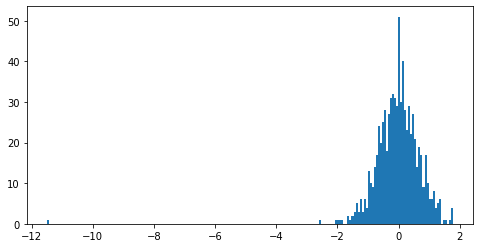

In [0]:
# For the 5th token in our sentence, select its feature values from layer 5.
token_i = 5
layer_i = 5
vec = encoded_layers[layer_i][batch_i][token_i]

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(8,4))
plt.hist(vec, bins=200)
plt.show()

In [0]:
# `encoded_layers` is a Python list.
print('Type of encoded_layers: ', type(encoded_layers))

# Each layer in the list is a torch tensor.
print('Tensor shape for each layer: ', encoded_layers[0].size())

Type of encoded_layers:  <class 'list'>
Tensor shape for each layer:  torch.Size([1, 15, 768])


# Token Vectors

In [0]:
# Concatenate the tensors for all layers. We use `stack` here to
# create a new dimension in the tensor.
token_embeddings = torch.stack(encoded_layers, dim=0)
token_embeddings.size()

torch.Size([12, 1, 15, 768])

In [0]:
# Remove dimension 1, the "batches".
token_embeddings = torch.squeeze(token_embeddings, dim=1)
token_embeddings.size()

torch.Size([12, 15, 768])

In [0]:
# switch around the “layers” and “tokens” dimensions
# Swap dimensions 0 and 1.
token_embeddings = token_embeddings.permute(1,0,2)
token_embeddings.size()

torch.Size([15, 12, 768])

In [0]:
# Stores the token vectors, with shape [15 x 3,072]
token_vecs_cat = []

# `token_embeddings` is a [15 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:
    
    # `token` is a [12 x 768] tensor

    # Concatenate the vectors (that is, append them together) from the last 
    # four layers.
    # Each layer vector is 768 values, so `cat_vec` is length 3,072.
    cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
    
    # Use `cat_vec` to represent `token`.
    token_vecs_cat.append(cat_vec)

print ('Shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))

Shape is: 15 x 3072


In [0]:
# Stores the token vectors, with shape [15 x 768]
token_vecs_sum = []

# `token_embeddings` is a [15 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)
    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Shape is: 15 x 768


# Sentence Vectors

In [0]:
# `encoded_layers` has shape [12 x 1 x 15 x 768]

# `token_vecs` is a tensor with shape [15 x 768]
token_vecs = encoded_layers[11][0]

# Calculate the average of all 15 token vectors.
sentence_embedding = torch.mean(token_vecs, dim=0)

print ("Our final sentence embedding vector of shape:", sentence_embedding.size())

Our final sentence embedding vector of shape: torch.Size([768])


# Token Vector Cosine Similarity

In [0]:
for i, token_str in enumerate(tokenized_text):
    print (i, token_str)

0 [CLS]
1 service
2 was
3 awesome
4 drinks
5 were
6 strong
7 and
8 ta
9 ##sty
10 .
11 food
12 was
13 great
14 [SEP]


In [0]:
print('First 5 vector values for 3 adjectives.')
print("awesome ", str(token_vecs_sum[3][:5]))
print("strong ", str(token_vecs_sum[6][:5]))
print("great ", str(token_vecs_sum[13][:5]))

First 5 vector values for 3 adjectives.
great  tensor([3.2793, 0.4395, 0.4706, 3.9851, 3.3688])
strong  tensor([-2.8577, -2.6828,  2.8643,  2.7328,  2.1268])
awesome  tensor([-0.0675,  0.7492, -1.2852,  3.2361,  1.3994])


In [0]:
from scipy.spatial.distance import cosine

# similarity between "awesome" and "great" in this sentence
similarity_1 = 1 - cosine(token_vecs_sum[3], token_vecs_sum[13])
# similarity between "awesome" and "strong" in this sentence
similarity_2 = 1 - cosine(token_vecs_sum[3], token_vecs_sum[6])

print('Vector similarity for  *similar*  meanings:  %.2f' % similarity_1)
print('Vector similarity for *different* meanings:  %.2f' % similarity_2)

Vector similarity for  *similar*  meanings:  0.84
Vector similarity for *different* meanings:  0.55


# Sentence Vector Cosine Similarity

In [0]:
# locate the records containing "awesome", "strong" and "great"
df_tmp = df_tip.dropna()[df_tip['text'].dropna().str\
                         .contains("^(?=.*awesome)(?=.*strong)(?=.*great).+", 
                                   flags=re.IGNORECASE, regex=True)]
print(df_tmp.shape)
df_tmp[['text', 'compliment_count']]

(11, 5)


,text,compliment_count
194157,Awesome guy and a great service. I would stron...,0
623316,Awesome coffee and strong and great customer s...,0
656748,"Great food, music and strong AC. There is a pa...",0
722313,"Awesome little coffee shop! Great atmosphere, ...",0
733967,Service was great drinks were strong and uniqu...,0
834502,"Awesome ambience, great sliders and strong hap...",0
877995,The bartender Melanie is awesome. Great drinks...,0
906875,Awesome food!! Great service. Armstrongs is aw...,0
960644,Strong! And by strong I mean awesome although ...,0
985927,This awesome place has great service and excel...,0


In [0]:
# locate the records containing "terrible" and "disappointing"
df_tmp = df_tip.dropna()[df_tip['text'].dropna().str\
                         .contains("^(?=.*terrible)(?=.*disappointing).+", 
                                   flags=re.IGNORECASE, regex=True)]
print(df_tmp.shape)
df_tmp[['text', 'compliment_count']]

(26, 5)


,text,compliment_count
62151,Disappointing menu. No veal or lamb. Short rib...,0
182509,Very disappointing especially for the price! S...,0
207873,Free wifi.. And today 08/30/15 Lisa our server...,0
274184,Found the food terrible the last 2 visits. Th...,0
305520,Luis (friendly/laid back) = good bartender. G...,0
441496,Terrible! Tried it a few times just to give a ...,0
724297,Extremely disappointing experience. Received ...,0
759825,I'm sorry but I cannot give this restaurant a ...,0
795184,Extremely disappointing. The food was not good...,0
799403,Terrible service at the restaurant it took an ...,0


In [8]:
%%time
# choose two positive and two negative tip texts
indices = [194157, 623316, 62151, 182509]
embeddings = []

for idx in indices:
    text = df_tip.loc[idx, 'text']
    marked_text = "[CLS] " + text + " [SEP]"
    # Tokenize our sentence with the BERT tokenizer.
    tokenized_text = tokenizer.tokenize(marked_text)
    # Map the token strings to their vocabulary indices.
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    # Mark each of the 22 tokens as belonging to sentence "1".
    segments_ids = [1] * len(tokenized_text)
    # Convert inputs to PyTorch tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    # Predict hidden states features for each layer
    with torch.no_grad():
        encoded_layers, _ = model(tokens_tensor, segments_tensors)
    # Concatenate the tensors for all layers. We use `stack` here to
    # create a new dimension in the tensor.
    token_embeddings = torch.stack(encoded_layers, dim=0)
    # `token_vecs` is a tensor with shape [15 x 768]
    token_vecs = encoded_layers[11][0]
    # Calculate the average of all 15 token vectors.
    sentence_embedding = torch.mean(token_vecs, dim=0)
    embeddings.append(sentence_embedding)
'''
# for 4 tips
CPU times: user 665 ms, sys: 4.67 ms, total: 670 ms
Wall time: 839 ms
'''    

CPU times: user 665 ms, sys: 4.67 ms, total: 670 ms
Wall time: 839 ms


In [11]:
for i, e in enumerate(embeddings):
    similarity = 1 - cosine(embeddings[0], embeddings[i-3])
    print(df_tip.loc[indices[0], 'text'])
    print(df_tip.loc[indices[i-3], 'text'])
    print('Sentence vector similarity: %.2f' % similarity)
    print()
# what can this similarity explain? ヽ(•̀ω•́ )ゝ
# maybe just get the sentences with the highest similarity
# e.g. search though the tips for businesses in the same area
#      to propose similar businesses
# this should be combined with sentiment analysis?

Awesome guy and a great service. I would strongly recommend to anyone.
Awesome coffee and strong and great customer service!!
Sentence vector similarity: 0.71

Awesome guy and a great service. I would strongly recommend to anyone.
Disappointing menu. No veal or lamb. Short ribs were terrible
Sentence vector similarity: 0.62

Awesome guy and a great service. I would strongly recommend to anyone.
Very disappointing especially for the price! Server was terrible. My food order was wrong so I had to wait for them to cook the meal I ordered while I watched my husband finish his food.  Then when my dinner finally arrived I shoveled my food down because we both couldn't wait to get out of there. Great date night.  Won't be going back.
Sentence vector similarity: 0.67

Awesome guy and a great service. I would strongly recommend to anyone.
Awesome guy and a great service. I would strongly recommend to anyone.
Sentence vector similarity: 1.00

